# Insurance Premium Prediction

## Problem Statement



> **QUESTION**: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, **you're tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence. 
>
> Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. 
> 
>We have given a CSV file containing verified historical data, consisting of the aforementioned information and the actual medical expenses incurred by over 1300 customers. 

> Dataset source: [Kaggle](https://www.kaggle.com/noordeen/insurance-premium-prediction)
> 

# Data Gathering and Initial Insights

## Installing and Importing the required packages.

In [1]:
!pip3 install xgboost lightgbm 

  Using cached lightgbm-3.3.5-py3-none-win_amd64.whl (1.0 MB)
     ---------------------------------------- 8.3/8.3 MB 1.5 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 2.0 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\Tavishi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
!pip install missingno --q

In [5]:
## Version Tracking packages

## Data Analysis packages
import numpy as np
import pandas as pd

## Data Visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib
%matplotlib inline
from pylab import rcParams
import missingno as msno
import statsmodels

## General Tools
import os
import re
import joblib
import json
import warnings


# sklearn library
import sklearn

### sklearn preprocessing tools
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,accuracy_score,roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer,FunctionTransformer,OneHotEncoder


# Error Metrics 
from sklearn.metrics import r2_score #r2 square
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix ,classification_report
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score
 


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb


#crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import plot_confusion_matrix


#hyper parameter tunning
from sklearn.model_selection import GridSearchCV,cross_val_score,RandomizedSearchCV

# 
import pickle


## Downloading the Data
The dataset is from Kaggle. it provides cutting-edge data science, faster and better than most people ever thought possible. Kaggle offers both public and private data science competitions and on-demand consulting by an elite global talent pool.
When you execute od.download, you will be asked to provide your Kaggle username and API key. Follow these instructions to create an API key: http://bit.ly/kaggle-creds

Dataset link https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction?select=insurance.csv

In [6]:
# Let us load the dataset
df = pd.read_csv("insurance.csv")

In [7]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


### Observations:
The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

### Aim of the dataset
Our objective is to find a way to estimate the value in the "expenses" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [8]:
# Print the more information about the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" (body mass index) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [9]:
# Let us see statistical information about the Numerical features
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "expenses" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.


> 1. The range of expenses in the numerical column seems to have lot of difference in 75 percentile and the maximun expenses it looks like outliers. So we will handle that outlierr.
> 2. The range of the bmi in the numerical columns seems to have little difference in 75  percentile and the maximum bmi value.
> 3. Almost 50 percent of the customers have one child.

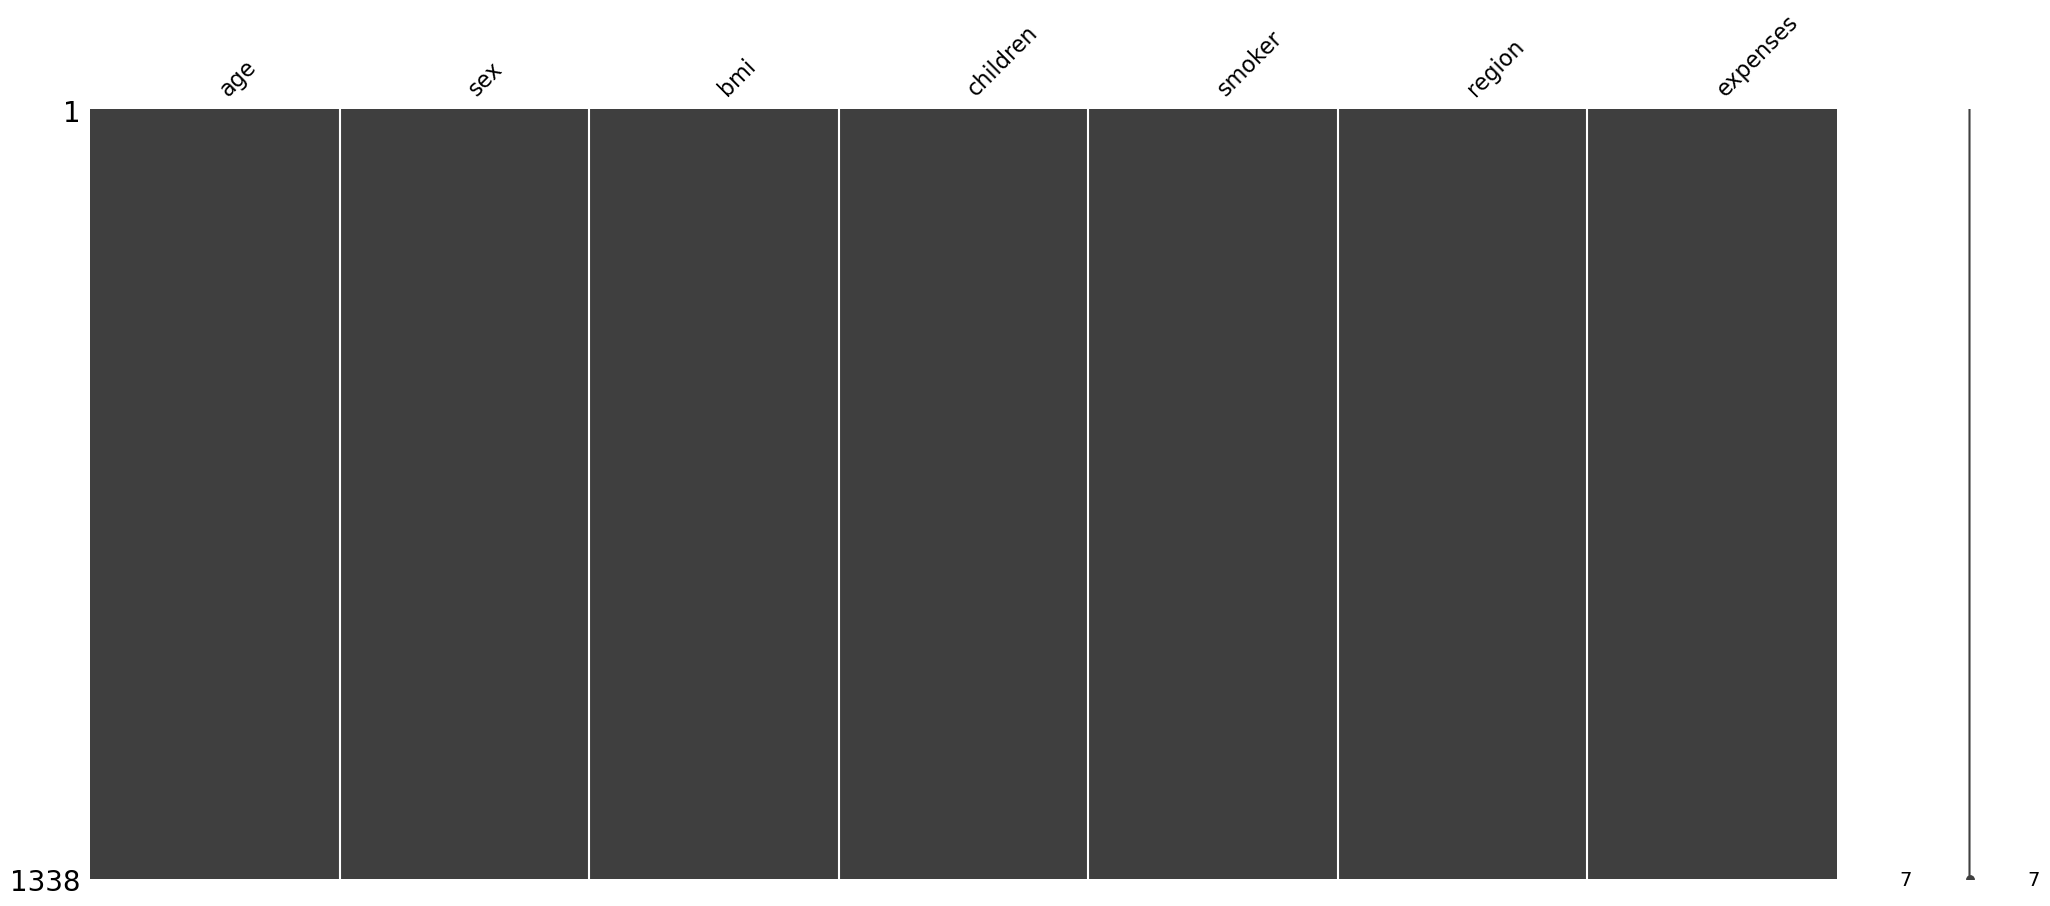

In [10]:
##Visualize missing values (NaN) values using Missingno Library
msno.matrix(df);

In [11]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

### Observations: 
- There is no null values in the dataset

### check duplicates

In [12]:
df.duplicated().sum()

1

In [13]:
### remove duplicates

In [14]:
df = df.drop_duplicates()
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [78]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [79]:
df.duplicated().sum()

0

### Observations
Now the data contains 1337 rows and 7 columns

In [80]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.22,14.04,18.00,27.00,39.00,51.00,64.00
bmi,1337.0,30.67,6.10,16.00,26.30,30.40,34.70,53.10
children,1337.0,1.10,1.21,0.00,0.00,1.00,2.00,5.00
expenses,1337.0,13279.12,12110.36,1121.87,4746.34,9386.16,16657.72,63770.43


### Dependent Variable

The "expenses" is our Target Varible.

In [81]:
df.columns[-1]

'expenses'

### Independent Variables or Features

In [82]:
df.columns[:-1]

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

### Numerical and categoriacl columns(features)

In [83]:
# numerical and categoriacl columns(features)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes('object').columns.tolist()

In [84]:
# numerical features
print("Total numeric columns are:", len(numeric_cols))
print(numeric_cols)

Total numeric columns are: 4
['age', 'bmi', 'children', 'expenses']


In [85]:
# categorical features
print("Total categorical columns are:", len(categorical_cols))
print(categorical_cols)

Total categorical columns are: 3
['sex', 'smoker', 'region']


## Exploratory Analysis and Visualization

Before training a machine learning model, its always a good idea to explore the distributions of various columns and see how they are related to the target column.Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "expenses" and other columns. We explore and visualize the data using the Plotly, Matplotlib and Seaborn libraries. 

The following settings will improve the default style and font sizes for our charts.

In [86]:
df.corr()

,age,bmi,children,expenses
age,1.000000,0.109414,0.041536,0.298308
bmi,0.109414,1.000000,0.012641,0.198637
children,0.041536,0.012641,1.000000,0.067389
expenses,0.298308,0.198637,0.067389,1.000000


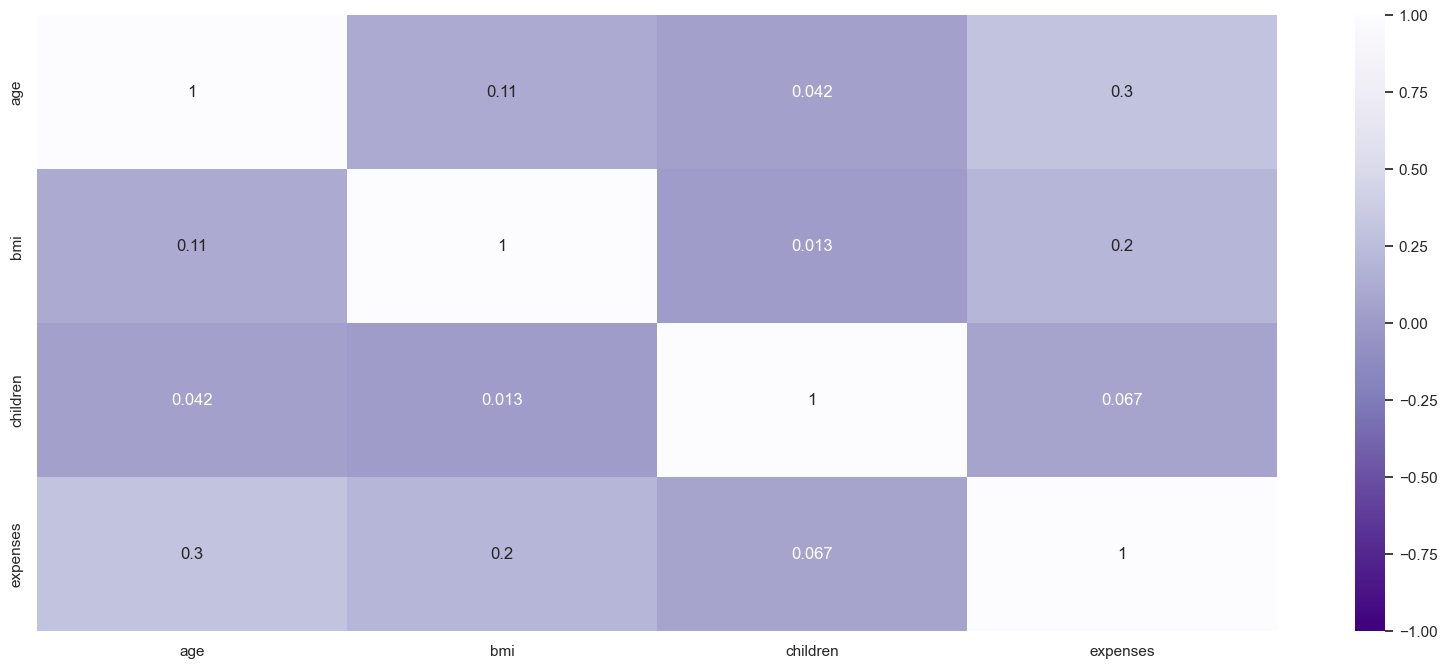

In [87]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap="Purples_r")
plt.show()

### Frequency Distribution of given Dataset in single Frame

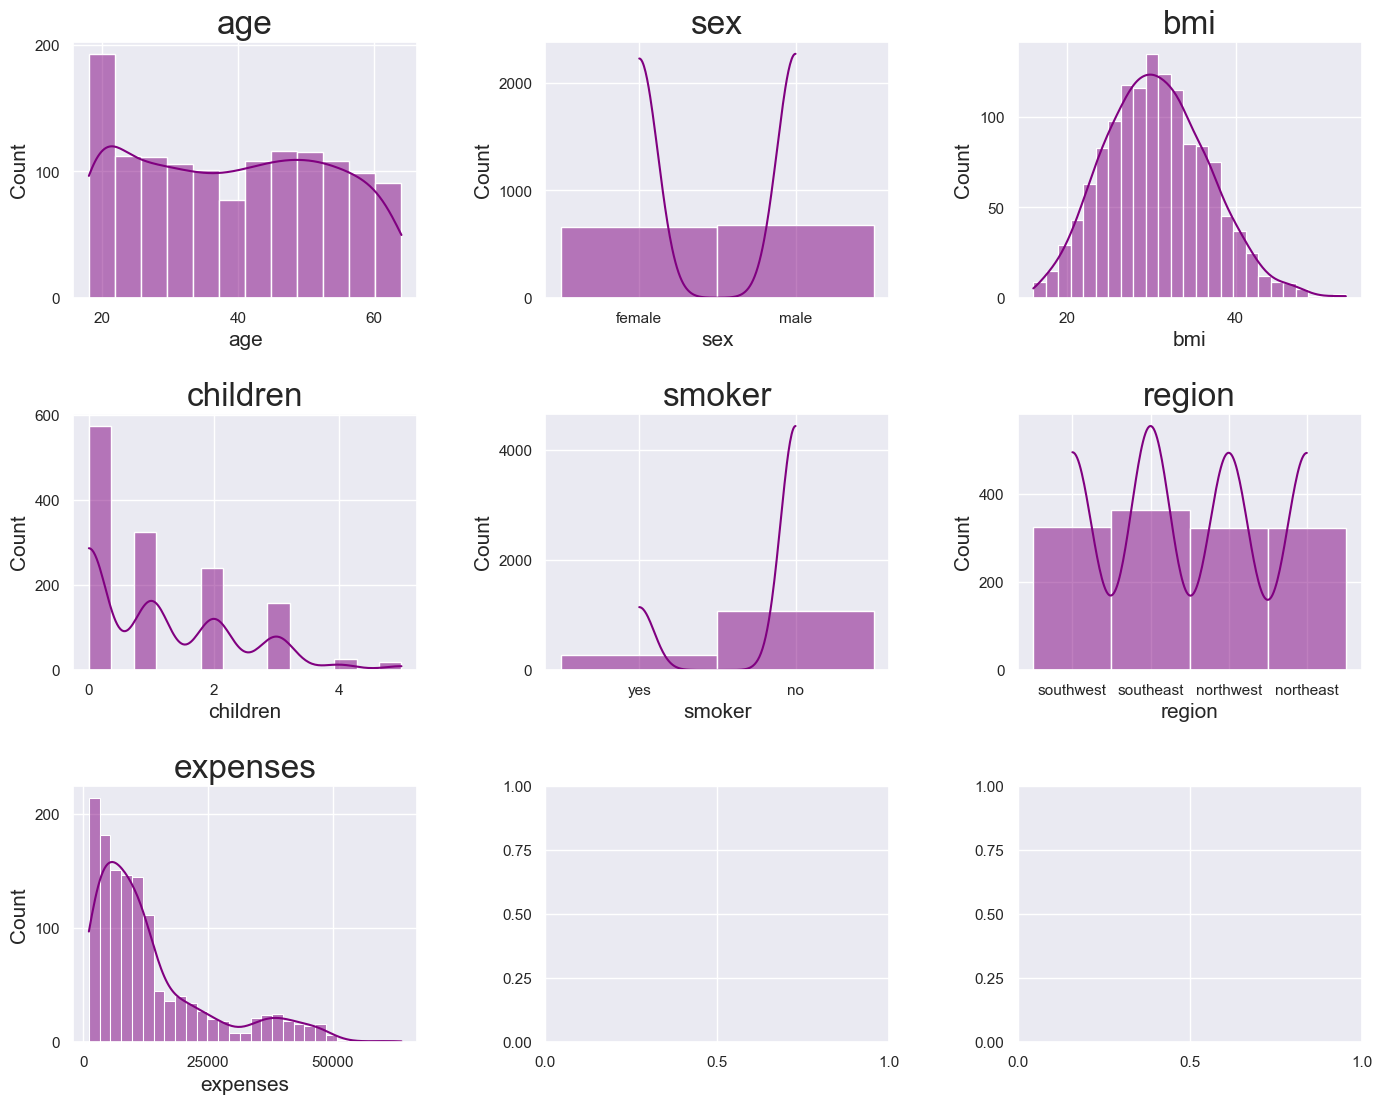

In [88]:
sns.set(rc={
            "font.size":15,
            "axes.titlesize":10,
            "axes.labelsize":15},
             style="darkgrid")
fig, axs = plt.subplots(3, 3, figsize=(15,12))

fig.tight_layout(pad=4.0)

for f,ax in zip(df,axs.ravel()):
    sns.set(font_scale = 2)
    ax=sns.histplot(ax=ax,data=df,x=df[f],kde=True,color='purple')
    ax.set_title(f)

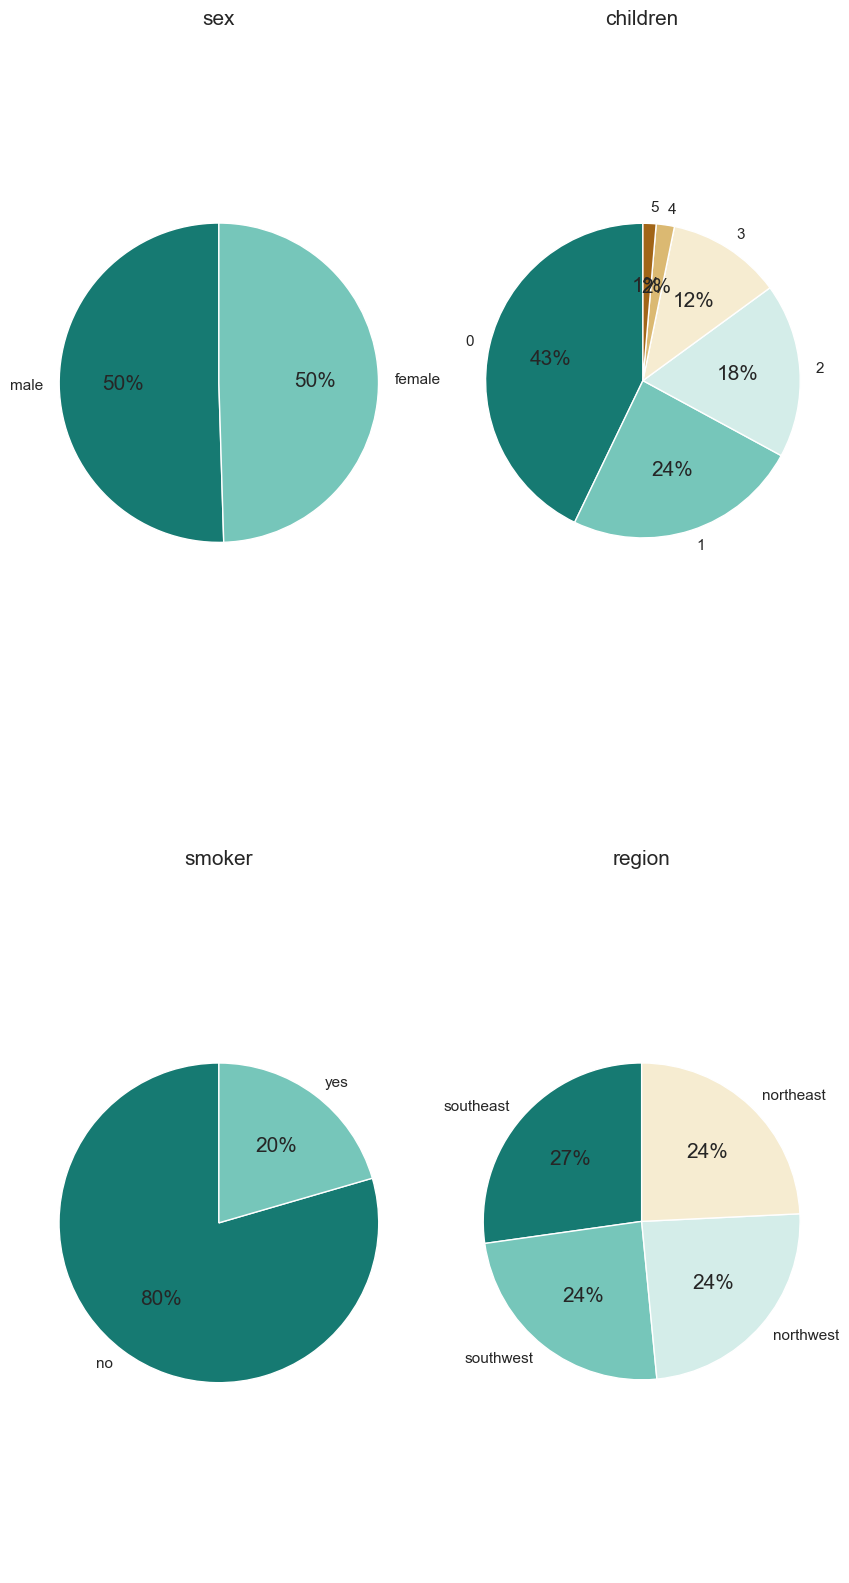

In [89]:
new_df=df.copy()
new_df.drop(["expenses","bmi","age"], axis=1, inplace=True)
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
sns.set(rc={
            "font.size":15,
            "axes.titlesize":15,
            "axes.labelsize":15},
             style="darkgrid")
fig, axes = plt.subplots(2, 2, figsize = (10, 20))
for i, col in enumerate(new_df):
    column_values = new_df[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    axes[i//2, i%2].pie(sizes,labels = labels, colors = sns.color_palette("BrBG_r"),autopct = '%1.0f%%', startangle = 90)
    axes[i//2, i%2].axis('equal')
    axes[i//2, i%2].set_title(col)
plt.show()


### Observations:
- male- 49% 
- female- 51%
- non smoker-80%
- smoker-20%
- northeast-24%
- northwest-24%
- southwest-24%
- southeast-27%

### Age
Age
Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [90]:
fig = px.histogram(df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age',
                  color_discrete_sequence=["orange"])
fig.update_layout(template='plotly_dark')
fig.update_layout(bargap=0.1)
fig.show()

In [91]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

<AxesSubplot:xlabel='bmi', ylabel='expenses'>

<Figure size 1000x500 with 0 Axes>

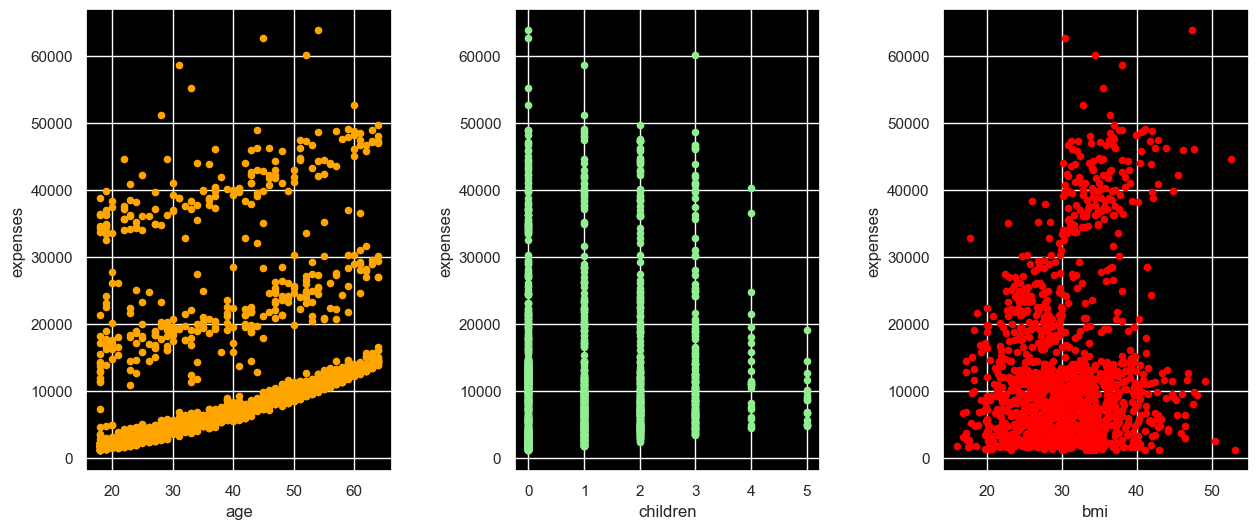

In [92]:
sns.set(rc={
            "font.size":10,
            "axes.titlesize":10,
            "axes.labelsize":13},)
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
plt.figure(figsize=(10,5), dpi=100)
fig, axes = plt.subplots(ncols = 3, figsize = (15,6), squeeze=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None,)
df.plot(kind='scatter', x='age', y='expenses', ax=axes[0],color = 'orange')
df.plot(kind='scatter', x='children', y='expenses', ax=axes[1],color = 'lightgreen')
df.plot(kind='scatter', x='bmi', y='expenses', ax=axes[2],color = 'red')

In [93]:
fig = px.histogram(df, x="sex",
                   color=df["sex"],
                   color_discrete_sequence=["teal","#DAA520"])

fig.update_layout(template='plotly_dark',
                 title="Distribution of Gender",
                 xaxis_title="Gender",
                 yaxis_title="count",
                 font_size=14,
                 showlegend=False)
fig.update_layout(bargap=0.2)
fig.show()

### Observations:
- male- 675
- female-662

In [94]:
fig = px.histogram(df, x="region",
                   color=df["region"],
                   color_discrete_sequence=["teal","#DAA520","pink","green"])

fig.update_layout(template='plotly_dark',
                 title="Distribution as per Region",
                 xaxis_title="Region",
                 yaxis_title="count",
                 font_size=14,
                 showlegend=False)
fig.update_layout(bargap=0.2)
fig.show()

### Observations:
- southwest- 325
- southeast- 364
- northwest- 324
- northeast- 324

In [95]:
fig = px.histogram(df,
                    x='bmi',
                    marginal='box',
                    color_discrete_sequence=['red'],
                    title='Distribustion of BMI (Body Mass Index)')

fig.update_layout(bargap=0.1,template='plotly_dark')
fig.show()

### Expenses

Let's visualize the distribution of "expenses" i.e. the annual medical expenses for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the expenses for smokers and non-smokers.

In [96]:
fig = px.histogram(df,
                    x='expenses',
                    marginal='box',
                    color='smoker',
                    color_discrete_sequence=['green', 'orange'],
                    title="Annual Medical Expenses")

fig.update_layout(bargap=0.1,template='plotly_dark')
fig.show()                   

### observations:

* For most customers, the annual medical expenses are under 10k. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is 7.3k, the median for smokers is close to 35k.


### Charges and Gender 

Let us visualize the distribution of "expenses" with the categorical column "sex" to distinguish the expenses for "male" and "female"

In [97]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="sex",
                    color_discrete_sequence=["purple", "pink"],
                    title="Annual Medical Expenses by Gender")

fig.update_layout(bargap=0.1,template='plotly_dark')
fig.show()                    

### observation:

* There is a significant difference in expenses between male and female. While the median for male and female is almost same but upper fence for male is 42k, the upper fence for female is close to 28k.

### DIstribution of expenses with Region

Let's visualize the distribution of "expenses" with categorical column "region" to distinguish expenses for southwest, southeast, northwest and northeast.

In [98]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="region",
                    color_discrete_sequence=["grey", "orange", "green","violet"],
                    title="Annual Medical Expenses by Region")

fig.update_layout(bargap=0.1,template='plotly_dark')
fig.show()                    

We make some obervation from the above graph

* There is significant difference in expenses for southeast, southwest, northeast and northwest. While the median for southwest is 8798 , the median for southeast is close to 9294, the median for northwest is 8965 and median for northeast is 10.05k.
*  And the upper fence for southwest is close to  26k, upper fence for southeast is close to 42k, upper fence for northwest is close to 4230kk and the upper fence for northeast is close to 34k.

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [99]:
fig=px.histogram(df, x="smoker", color="sex",color_discrete_sequence=["teal","#DAA520"])

fig.update_layout(template='plotly_dark',
                 title="Distribution of gender as per smokers",
                 xaxis_title="smoker",
                 yaxis_title="count",
                 showlegend=True)
fig.update_layout(bargap=0.2)
fig.show()

From the above graph we make some observations.

* It appears that 20% of the customers have reported they smoking.
* We can also see that smoking appears a more common habit among males.

In [100]:
# px.histogram(df, x="region", color="smoker", title="Region")

fig=px.histogram(df, x="region", color="smoker",color_discrete_sequence=["teal","#DAA520"])

fig.update_layout(template='plotly_dark',
                 title="Distribution of region as per smokers",
                 xaxis_title="smoker",
                 yaxis_title="count",
                 showlegend=True)
fig.update_layout(bargap=0.2)
fig.show()

In [101]:

fig=px.histogram(df, x="smoker", color="children",color_discrete_sequence=["teal","#DAA520","pink","lightblue","purple","red"])

fig.update_layout(template='plotly_dark',
                 title="Smoker Vs Children",
                 xaxis_title="smoker",
                 yaxis_title="count",
                 showlegend=True)
fig.update_layout(bargap=0.2)
fig.show()


### Distribution of data as per smoke

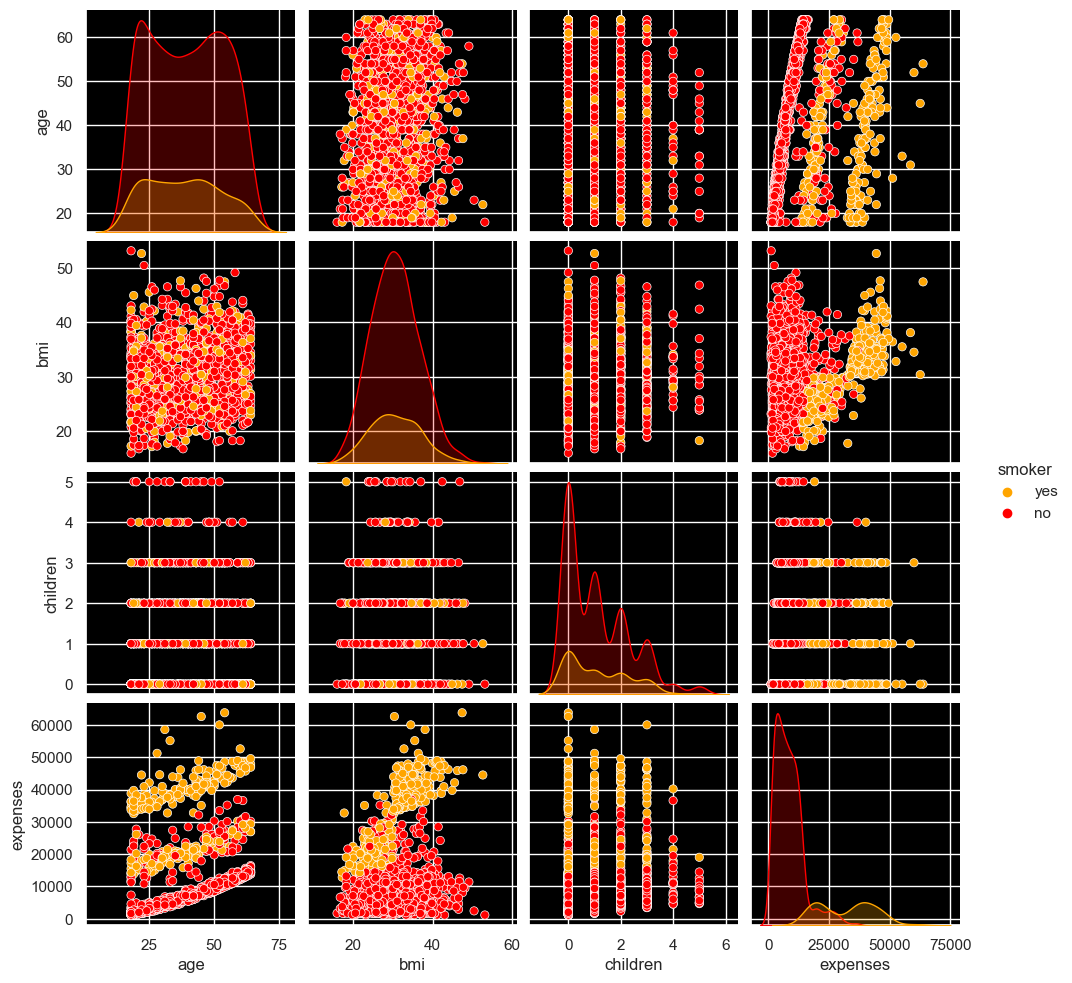

In [102]:
sns.set(style="ticks")
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
sns.pairplot(data=df, hue='smoker',palette=['orange','red'] )


Having looked at individual columns, we can now visualize the relationship between "expenses" (the value we wish to predict) and other columns.

### Age and Charges

Let's visualize the relationship between "age" and "expenses" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [103]:
fig = px.scatter(df,
                x="age",
                y="expenses",
                color="smoker",
                opacity=0.8,
                hover_data=["sex"],
                width=800,
                height=500,
                title="Age vs Expenses",
                color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')

fig.update_traces(marker_size=5)
fig.show()                

We can make the following observations from the above chart:

* The general trend seems to be that medical expenses increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical expenses.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical expenses compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.
     


### BMI and Expenses

Let's visualize the relationship between BMI (body mass index) and expenses using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [104]:
fig = px.scatter(df, x="bmi",y="expenses",
                   color="smoker",
                   color_discrete_sequence=["teal","#DAA520"],
                hover_data=['sex'],
                opacity=0.9,)

fig.update_layout(template='plotly_dark',
                 title="BMI Vs Expenses",
                 xaxis_title="BMI",
                 yaxis_title="Expenses",
                 showlegend=True)
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical expenses. However, medical expenses seem to be significantly higher for smokers with a BMI greater than 30.


In [105]:
fig = px.histogram(df, x="bmi",
                   y="expenses",
                   color="sex",
                   marginal="rug", 
                   hover_data=df.columns,
                  color_discrete_sequence=["teal","#DAA520"])

fig.update_layout(template='plotly_dark',
                 title="BMI Vs Sum of Expenses",
                 xaxis_title="BMI",
                 yaxis_title="Sum of Expenses",
                 showlegend=True)
fig.show()

In [106]:
fig = px.scatter(df, x="bmi", 
                 y="expenses", 
                 color='sex', 
                 facet_col="children",
                color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')

fig.update_xaxes(matches=None,)
fig.show()

In [107]:
fig = px.scatter(df, x="bmi", 
                 y="expenses",
                 color="sex",
                 width=900, 
                 height=500,
                 title="Expenses by BMI & Gender",
                color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')
fig.show()

In [108]:
fig = px.scatter(df, x="bmi"
                 , y="expenses", 
                 color="smoker",
                 width=900, height=500,
                 title="Expenses by BMI & Smoker",
                color_discrete_sequence=["teal","#DAA520"])
fig = px.scatter(df, x="bmi", 
                 y="expenses", 
                 color="region",
                 width=900, 
                 height=500, 
                 title="Expenses by BMI & Region",
                color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')
fig.show()

In [109]:
fig = px.scatter(df, x="bmi", 
                 y="expenses", 
                 color="region",
                 width=900, 
                 height=500, 
                 title="Expenses by BMI & Region",
                color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')
fig.show()


In [110]:
fig = px.violin(df, y="expenses", x= "sex",
                color="sex",
                color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')
fig.show()

From left plot the insurance charge for male and female is approximatley in same range,it is average around 50k.

In [111]:
fig = px.violin(df, y="expenses", x= "smoker",
                color="smoker",
                color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')
fig.show()

 In right plot the health expenses for smokers is much wide range compare to non smokers, the average expenses for non smoker is approximately 5000 bucks. For smoker the minimum health expenses is itself 5000 bucks.

In [112]:
fig = px.scatter(df, x="bmi", 
                 y="expenses", 
                 color="sex",
                 marginal_y="violin",
                 marginal_x="box", 
                 trendline="ols",
                 template="simple_white",
                 color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')
fig.show()

In [113]:
fig = px.scatter(df, x="bmi",
                 y="expenses",
                 color="smoker",
                 marginal_y="violin",
                marginal_x="box",
                 trendline="ols",
                 template="simple_white",
                 color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')
fig.show()

In [114]:
fig = px.scatter(df, x="bmi", y="expenses", color="region", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white",
                 color_discrete_sequence=["teal","#DAA520","red","pink"])
fig.update_layout(template='plotly_dark')
fig.show()

In [115]:
fig = px.box(df, x="children",
             y="expenses", 
             color="smoker",
             notched=True, 
             title= "Expenses by Children & Smoker",color_discrete_sequence=["teal","#DAA520"])
fig.update_layout(template='plotly_dark')
fig.show()


To compute the correlation for categorical columns, they must first be converted into numeric columns.

## StandardScaler and OneHotEncoder

In [116]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

In [117]:
numeric_features = ['age', 'bmi', 'children']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['sex', 'smoker','region']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## Train test split

In [118]:
X = df.drop('expenses',axis=1)
y = df['expenses']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
print("shape of Train Data ", X_train.shape)
print("shape of Test Data ",y_test.shape)

shape of Train Data  (1069, 6)
shape of Test Data  (268,)


## Creating Pipeline

In [121]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('linear_regressor', LinearRegression())])
pipeline_dt = Pipeline(steps=[('preprocessor',preprocessor),('decision_tree_regressor', DecisionTreeRegressor())])
pipeline_knn = Pipeline(steps=[('preprocessor',preprocessor),('knn',KNeighborsRegressor(n_neighbors=7))])
pipeline_rf = Pipeline(steps=[('preprocessor',preprocessor),('random_forest',RandomForestRegressor())])
pipeline_gb = Pipeline(steps=[('preprocessor',preprocessor),('gradient_boosting', GradientBoostingRegressor())])
pipeline_xgb= Pipeline(steps=[('preprocessor', preprocessor),('xgb', xgb.XGBRegressor())])

In [122]:
pipelines = [pipeline_dt,pipeline_gb,pipeline_knn,pipeline_lr,pipeline_rf,pipeline_xgb]

In [123]:
pipe_dict = {0:'Linear Regression',1:'Decision Tree',2:'KNN',3:'Random forest',4:'Gradient boosting',5:'pipeline_xgb'}

In [124]:
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [125]:
for i, model in enumerate(pipelines):
    print(f"{pipe_dict[i]} Test accuarcy: {model.score(X_test,y_test)}")

Linear Regression Test accuarcy: 0.7780066466339479
Decision Tree Test accuarcy: 0.8974964903747812
KNN Test accuarcy: 0.7591667892166825
Random forest Test accuarcy: 0.806909932904842
Gradient boosting Test accuarcy: 0.8815513825990082
pipeline_xgb Test accuarcy: 0.8589651598244689


## Model performance using evaluation metrics

### Linear Regression

In [126]:
linear_reg = Pipeline(steps=[('prepocessor', preprocessor), ('linear_regressor', LinearRegression())])

linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

linear_reg_mse = mean_squared_error(y_test, y_pred)
linear_reg_rmse = mean_squared_error(y_test, y_pred, squared=False)
linear_reg_r2_score = r2_score(y_test, y_pred)


print(f"The Mean Squared Error using Linear Regression :{linear_reg_mse}")
print(f"The Root Mean Squared Error using Linear Regression :{linear_reg_rmse}")
print(f"The r2_score using Linear Regression :{linear_reg_r2_score}")

The Mean Squared Error using Linear Regression :35481471.59594917
The Root Mean Squared Error using Linear Regression :5956.63257184369
The r2_score using Linear Regression :0.806909932904842


### Decision Tree

In [127]:
decision_tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('decision_tree_regressor', DecisionTreeRegressor(max_depth=4, 
                                                                        min_samples_split=6,
                                                                        random_state=42 ))])
decision_tree.fit(X_train, y_train)
y_pred1 = decision_tree.predict(X_test)


decision_tree_mse = mean_squared_error(y_test, y_pred)
decision_tree_rmse = mean_squared_error(y_test, y_pred1, squared=False)
decision_tree_r2_score = r2_score(y_test, y_pred1)

print(f"The Mean Squared Error using Decision Tree Regressor : {decision_tree_mse}")
print(f"The Root Mean Squared Error using Decision Tree Regressor : {decision_tree_rmse}")
print(f"The r2_score using Decision Tree Regressor : {decision_tree_r2_score}")

The Mean Squared Error using Decision Tree Regressor : 35481471.59594917
The Root Mean Squared Error using Decision Tree Regressor : 4276.481374705962
The r2_score using Decision Tree Regressor : 0.900475162004601


## Random Forest

In [128]:
random_forest_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('random_forest_regressor', RandomForestRegressor(n_estimators=100,
                                                                          max_depth=6,
                                                                          random_state=42))])
random_forest_reg.fit(X_train, y_train)                        

# Predicting the model
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = mean_squared_error(y_test, y_pred2, squared=False)
random_forest_r2_score = r2_score(y_test, y_pred2)

print(f"The Mean Squared Error using Random Forest Regressor : {random_forest_mse}")
print(f"The Root Mean Squared Error using Random Forest Regressor : {random_forest_rmse}")
print(f"The r2_score Error using Random Forest Regressor : {random_forest_r2_score}")

The Mean Squared Error using Random Forest Regressor : 18592280.620238423
The Root Mean Squared Error using Random Forest Regressor : 4311.87669353362
The r2_score Error using Random Forest Regressor : 0.8988208619615512


### Random Forest

In [129]:
random_forest_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('random_forest_regressor',
                         RandomForestRegressor(n_estimators=30,
                                               max_depth=8,
                                               min_samples_split=5
                                               ,random_state=42))])
random_forest_reg.fit(X_train, y_train)                        

# Predicting the model
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = mean_squared_error(y_test, y_pred2, squared=False)
random_forest_r2_score = r2_score(y_test, y_pred2)

print(f"The Mean Squared Error using Random Forest Regressor : {random_forest_mse}")
print(f"The Root Mean Squared Error using Random Forest Regressor : {random_forest_rmse}")
print(f"The r2_score Error using Random Forest Regressor : {random_forest_r2_score}")

The Mean Squared Error using Random Forest Regressor : 19687179.822855935
The Root Mean Squared Error using Random Forest Regressor : 4437.023757301276
The r2_score Error using Random Forest Regressor : 0.8928624236277819


### Gradient Boosting

In [130]:
gradient_boosting_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient_boosting' ,
                         GradientBoostingRegressor(n_estimators=41, 
                                                   max_depth=3, 
                                                   min_samples_split=5,
                                                   random_state=42))])

gradient_boosting_reg.fit(X_train, y_train)

# Predicting the model
y_pred3 = gradient_boosting_reg.predict(X_test)

# Evaluation Metrics
gradient_boosting_mse = mean_squared_error(y_test, y_pred3)
gradient_boosting_rmse = mean_squared_error(y_test, y_pred3, squared=False)
gradient_boosting_r2_score = r2_score(y_test, y_pred3)

print(f"The Mean Squared Error using Gradient Boosting Regressor : {gradient_boosting_mse}")
print(f"The Root Mean Squared Error using Gradient Boosting Regressor : {gradient_boosting_rmse}")
print(f"The r2_sccore using Gradient Boosting Regressor : {gradient_boosting_r2_score}")

The Mean Squared Error using Gradient Boosting Regressor : 18287158.95415804
The Root Mean Squared Error using Gradient Boosting Regressor : 4276.348787711082
The r2_sccore using Gradient Boosting Regressor : 0.9004813331969769


### KNN

In [131]:
knn = Pipeline(steps=[('preprocessor', preprocessor),
                ('knn', KNeighborsRegressor(n_neighbors=4))])

knn.fit(X_train, y_train)

# Predictiong The model
y_pred4 = knn.predict(X_test)

# Evaluation Metrics
knn_mse = mean_squared_error(y_test, y_pred4)
knn_rmse = mean_squared_error(y_test, y_pred4, squared=False)
knn_r2_score = r2_score(y_test, y_pred4)

print(f"The mean squared error using KNN is {knn_mse}")
print(f"The root mean squared error using KNN is {knn_rmse}")
print(f"The r2_score using KNN is knn_r2_score{knn_r2_score}")

The mean squared error using KNN is 36044437.93547064
The root mean squared error using KNN is 6003.702019210367
The r2_score using KNN is knn_r2_score0.8038462716929173


### XGBoost

In [132]:
xgb_reg = Pipeline(steps=[('preprocessor', preprocessor),
                ('xgb', xgb.XGBRegressor())])

xgb_reg.fit(X_train, y_train)

# Predicting the moodel
y_pred5 = xgb_reg.predict(X_test)

# Evaluation Metrics
xgb_reg_mse = mean_squared_error(y_test, y_pred5)
xgb_reg_rmse = mean_squared_error(y_test, y_pred5, squared=False)
xgb_reg_r2_score = r2_score(y_test, y_pred5)

print(f"The mean square error using XGBoost is {xgb_reg_mse}")
print(f"The root mean_squared error using XGBoost is {xgb_reg_rmse}")
print(f"The r2 score using XGBoost is {xgb_reg_r2_score}")

The mean square error using XGBoost is 25916007.752284974
The root mean_squared error using XGBoost is 5090.776733690545
The r2 score using XGBoost is 0.8589651598244689


In [133]:
models = pd.DataFrame({
    'Model' : ['Linear Regression', 'Decision Tree', 'Random Forest',
               'Gradient Boosting', 'KNN', 'XGBoost'],
    'RMSE' : [linear_reg_rmse, decision_tree_rmse, random_forest_rmse,
            gradient_boosting_rmse, knn_rmse, xgb_reg_rmse],
    'r2_score' : [linear_reg_r2_score, decision_tree_r2_score, random_forest_r2_score, 
    gradient_boosting_r2_score, knn_r2_score, xgb_reg_r2_score]
})

models.sort_values(by='RMSE', ascending=True)

,Model,RMSE,r2_score
3,Gradient Boosting,4276.348788,0.900481
1,Decision Tree,4276.481375,0.900475
2,Random Forest,4437.023757,0.892862
5,XGBoost,5090.776734,0.858965
0,Linear Regression,5956.632572,0.806910
4,KNN,6003.702019,0.803846


From the above observation we can say that the performance (RMSE & R-sqaured) of Gradient boosting model is good as compared to other models. So we will save Gradient boosting model for further testing of the data using pickle library.

In [134]:
pickle.dump(gradient_boosting_reg, open('gbr_model.pkl', 'wb'))

In [138]:
with open ('gbr_model.pkl', 'rb') as grb:
    loaded_model= pickle.load(grb)
    